In [84]:
import numpy as np
from scipy.special import digamma, gammaln, comb, perm, gamma,beta
from scipy.stats import beta,dirichlet
import matplotlib.pyplot as plt
import math
from scipy.stats import binom
import csv

In [85]:
class gibbs:
    def __init__(self,X):
        self.X = X
        self.n = len(X)
        
    def initialization(self, alpha=0.75, a=0.5, b=0.5, num_c=30):
        idx = np.random.randint(0, num_c, size = self.n)
        self.idx = np.zeros((self.n, num_c))
        self.idx[np.arange(self.n), idx] = 1
        self.theta = np.random.beta(a, b, size=(1,num_c))
        self.alpha = alpha
        self.a = a
        self.b = b
        
    def clean_idx(self):
        zero_clusters = np.where(np.sum(self.idx, axis=0)==0)[0]
        self.idx = np.delete(self.idx, zero_clusters, axis=1)
        self.theta = np.delete(self.theta, zero_clusters, axis=1)
                    
    def sample_index(self,i):
        ci = np.argmax(self.idx[i])
        self.idx[i][ci] = 0
        self.clean_idx()
        ## nj(-i) > 0
        temp_phi = binom.pmf(self.X[i][0], 20, self.theta)*np.sum(self.idx, axis=0, keepdims=True)/(self.alpha+self.n-1)
        ## new index
        new_prob = (self.alpha/(self.alpha+self.n-1))*(comb(20,self.X[i][0])*gamma(self.a+self.b)/(gamma(self.a)*gamma(self.b))*gamma(self.X[i][0]+self.a)*gamma(20-self.X[i][0]+self.b)/gamma(self.a+self.b+20))
        temp_phi = np.append(temp_phi, np.array([[new_prob]]), axis = 1)
        temp_phi = temp_phi/np.sum(temp_phi)
        self.temp_phi = temp_phi
        # sample
        c_new = np.random.choice(np.arange(len(temp_phi[0])), p = temp_phi[0])
                               
        if c_new == len(temp_phi[0]) - 1:
        # new index
            new_cluster = np.zeros((self.n, 1))
            new_cluster[i][0] = 1
            self.idx = np.append(self.idx, new_cluster, axis = 1)
            new_theta = np.random.beta(self.X[i][0]+self.a, 20-self.X[i][0]+self.b)
            self.theta = np.append(self.theta, np.array([[new_theta]]), axis=1)
        else:
            self.idx[i][c_new] = 1
            # sample data
            a_post_i = np.dot(self.X.T, self.idx[:, c_new])[0] + self.a
            b_post_i = np.dot((20-self.X).T, self.idx[:, c_new])[0] + self.b
            # update data
            self.theta[0][c_new] = np.random.beta(a_post_i, b_post_i)
    def sample_theta(self):
        a_post = np.dot(self.X.T, self.idx) + self.a
        b_post = np.dot((20-self.X).T, self.idx) + self.b
        self.theta = np.random.beta(a_post, b_post)
                               
    def run_algo(self, iterations = 1000):
        self.six_largest_clusters = np.zeros((iterations, 6))
        self.total_clusters = np.zeros((iterations, 1))
        
        self.initialization()
        for t in range(iterations):
        # sample ci
            for i in range(self.n):
                self.sample_index(i)
        # sample theta
            self.sample_theta()
                               
            # record
            # total_clusters
            self.total_clusters[t][0] = len(self.theta[0])
            ## observations for the six most probable clusters
            obs_in_clusters = np.sum(self.idx, axis = 0)
            obs_in_clusters = np.sort(obs_in_clusters)[::-1]
            if len(obs_in_clusters) >= 6:
                self.six_largest_clusters[t] = obs_in_clusters[:6]
            else:
                self.six_largest_clusters[t][:len(obs_in_clusters)] = obs_in_clusters
            if t%10 == 0:
                print("iteration %s is done" %t)

In [86]:
def fetch_data():
    reader = csv.reader(open("x.csv", "r"), delimiter=",")
    x = list(reader)
    x_input = np.array(x).astype("int")
    return x_input
fetch_data()

array([[ 4],
       [18],
       [16],
       ...,
       [ 3],
       [ 3],
       [17]])

In [87]:
if __name__ == '__main__':
    X = fetch_data()
    gibbs = gibbs(X)
    gibbs.run_algo()

iteration 0 is done
iteration 10 is done
iteration 20 is done
iteration 30 is done
iteration 40 is done
iteration 50 is done
iteration 60 is done
iteration 70 is done
iteration 80 is done
iteration 90 is done
iteration 100 is done
iteration 110 is done
iteration 120 is done
iteration 130 is done
iteration 140 is done
iteration 150 is done
iteration 160 is done
iteration 170 is done
iteration 180 is done
iteration 190 is done
iteration 200 is done
iteration 210 is done
iteration 220 is done
iteration 230 is done
iteration 240 is done
iteration 250 is done
iteration 260 is done
iteration 270 is done
iteration 280 is done
iteration 290 is done
iteration 300 is done
iteration 310 is done
iteration 320 is done
iteration 330 is done
iteration 340 is done
iteration 350 is done
iteration 360 is done
iteration 370 is done
iteration 380 is done
iteration 390 is done
iteration 400 is done
iteration 410 is done
iteration 420 is done
iteration 430 is done
iteration 440 is done
iteration 450 is done

Text(0, 0.5, 'Counts')

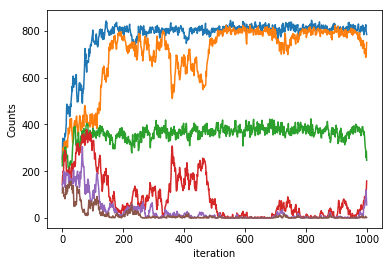

In [88]:
for i in range(6):
    plt.plot(range(1000), gibbs.six_largest_clusters[:,i])
plt.xlabel('iteration')
plt.ylabel('Counts')

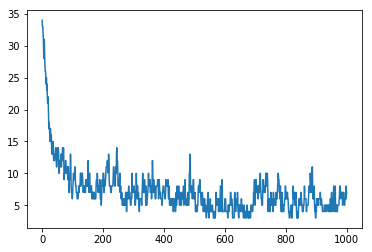

In [92]:
plt.plot(range(1000), gibbs.total_clusters[:,0])